In [3]:
# Import the necessary libraries
import ee
import xarray as xr
import pandas as pd
import rioxarray # Ensures the .rio accessor is available on xarray objects
from tqdm import tqdm
import requests
import io
import pandas as pd # Import pandas for easy timestamp conversion

def get_s2_collection(ds_velox):   #we should adapt this; this was meant for an imager but als works for tracks data;
    # still renaming needed
    poi = ee.Geometry.Rectangle(
        ds_velox.lons.min().item(),
        ds_velox.lats.min().item(),
        ds_velox.lons.max().item(),
        ds_velox.lats.max().item(),
    )


    export_region_ll = poi#.buffer(5000).bounds()
    TARGET_CRS = 'EPSG:3413'
    TARGET_SCALE = 10

    date = ds_velox.time[0].dt.strftime('%Y-%m-%d').item()
    date_end = (ds_velox.time[0] + pd.Timedelta(days=1)).dt.strftime('%Y-%m-%d').item()

    velox_time = ds_velox.time[0].item()

    # 1. Define the Image Collection
    # We'll use a wider date range to get more images
    collection = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(poi) \
        .filterDate(date, date_end) \
        .sort('system:time_start') # Sort by time

    # 2. Get Image IDs and Timestamps from the Collection
    # .aggregate_array() gets a list of properties from the collection.
    # .getInfo() brings that list from the server to our script.
    image_ids = collection.aggregate_array('system:id').getInfo()
    timestamps_ms = collection.aggregate_array('system:time_start').getInfo()

    print(f"Found {len(image_ids)} images to process.")

    # 3. Loop, Download, and Collect DataArrays
    data_arrays = []
    for i, image_id in enumerate(image_ids):
        print(f"Processing image {i+1}/{len(image_ids)}: {image_id}")
        
        image = ee.Image(image_id)

                
        try:
            # Get the download URL for the current image
            url = image.getDownloadURL({
                'bands': ['B3'],
                'region': export_region_ll,
                'scale': TARGET_SCALE,
                'crs': TARGET_CRS,
                'format': 'GEO_TIFF'
            })
        
        except Exception as e:
            print(f"Error getting download URL for image {image_id}: {e}")
            print("Trying lower scale (20m)...")
            try:
                url = image.getDownloadURL({
                    'bands': ['B3'],
                    'region': export_region_ll,
                    'scale': 20,
                    'crs': TARGET_CRS,
                    'format': 'GEO_TIFF'
                })
            except Exception as e2:
                print(f"Failed again for image {image_id}: {e2}")
                print("Continuing with next image...")
                continue

        # Download the GeoTIFF
        response = requests.get(url)
        response.raise_for_status()
        
        # Open in memory with rioxarray
        tiff_data = io.BytesIO(response.content)
        data_array = rioxarray.open_rasterio(tiff_data)
    
        # Add the single DataArray to our list
        data_arrays.append(data_array)
    # 4. Combine into a single xarray object with a time coordinate
    if data_arrays:
        # Convert GEE timestamps (milliseconds) to a datetime format
        time_coords = pd.to_datetime(timestamps_ms, unit='ms')

        # Concatenate all DataArrays along a new 'time' dimension
        s2_collection_ds = xr.concat(data_arrays, dim='time')

        # Assign the timestamps to the new 'time' coordinate
        s2_collection_ds = s2_collection_ds.assign_coords(time=time_coords)
        
        # Clean up the dataset for clarity
        # rioxarray adds a 'band' dimension of size 1, we can remove it.
        # The variable is named by its band number (e.g., 1), we can rename it.
        s2_collection_ds = s2_collection_ds.squeeze('band').rename('B3')

        print("\n✅ Complete collection successfully exported to xarray.")
        #display(s2_collection_ds)
    else:
        print("\nNo images found to process.")
        return None


    return s2_collection_ds



ee.Authenticate(auth_mode='notebook')

sau_tief = [
slice('2024-04-10T09:30:00', '2024-04-10T09:44:00'),
slice('2024-04-10T11:10:00', '2024-04-10T11:27:00'),
slice('2024-04-11T09:10:00', '2024-04-11T09:20:00'),
slice('2024-04-11T11:10:00', '2024-04-11T11:43:00'),
slice('2024-04-13T10:01:00', '2024-04-13T10:22:00'),
slice('2024-04-13T11:48:00', '2024-04-13T12:13:00'),
slice('2024-04-15T10:15:00', '2024-04-15T10:47:00'),
slice('2024-04-15T12:12:00', '2024-04-15T12:43:00'),
slice('2024-04-17T14:29:00', '2024-04-17T14:47:00'),
slice('2024-04-17T15:11:00', '2024-04-17T15:29:00'),
slice('2024-04-23T09:33:00', '2024-04-23T09:50:00'),
slice('2024-04-23T11:19:00', '2024-04-23T11:37:00'),
slice('2024-04-26T11:49:00', '2024-04-26T12:07:00'),
]

ee.Initialize(
    opt_url='https://earthengine-highvolume.googleapis.com'
)


ds_track = xr.open_dataset('../../../data/observations/processed/polar6_unified/mastertracks_unified.nc').rename(
{'latitude' : 'lats', 'longitude': 'lons'}
)



In [6]:
time_slice = sau_tief[8]
print(f"Processing time slice: {time_slice}")
ds_track_sel = ds_track.sel(time=time_slice)
s2_scene = get_s2_collection(ds_track_sel)#.to_netcdf(f'/projekt_agmwend/home_rad/Joshua/Sentinel-2_MODIS/BACSAM_II/{name}.nc', mode='w')

Processing time slice: slice('2024-04-17T14:29:00', '2024-04-17T14:47:00', None)
Found 7 images to process.
Processing image 1/7: COPERNICUS/S2_SR_HARMONIZED/20240417T123659_20240417T123657_T33XWK
Error getting download URL for image COPERNICUS/S2_SR_HARMONIZED/20240417T123659_20240417T123657_T33XWK: Total request size (116886840 bytes) must be less than or equal to 50331648 bytes.
Trying lower scale (20m)...
Processing image 2/7: COPERNICUS/S2_SR_HARMONIZED/20240417T132721_20240417T132720_T33XWL
Error getting download URL for image COPERNICUS/S2_SR_HARMONIZED/20240417T132721_20240417T132720_T33XWL: Total request size (116886840 bytes) must be less than or equal to 50331648 bytes.
Trying lower scale (20m)...
Processing image 3/7: COPERNICUS/S2_SR_HARMONIZED/20240417T132721_20240417T132720_T33XWK
Error getting download URL for image COPERNICUS/S2_SR_HARMONIZED/20240417T132721_20240417T132720_T33XWK: Total request size (116886840 bytes) must be less than or equal to 50331648 bytes.
Tryin

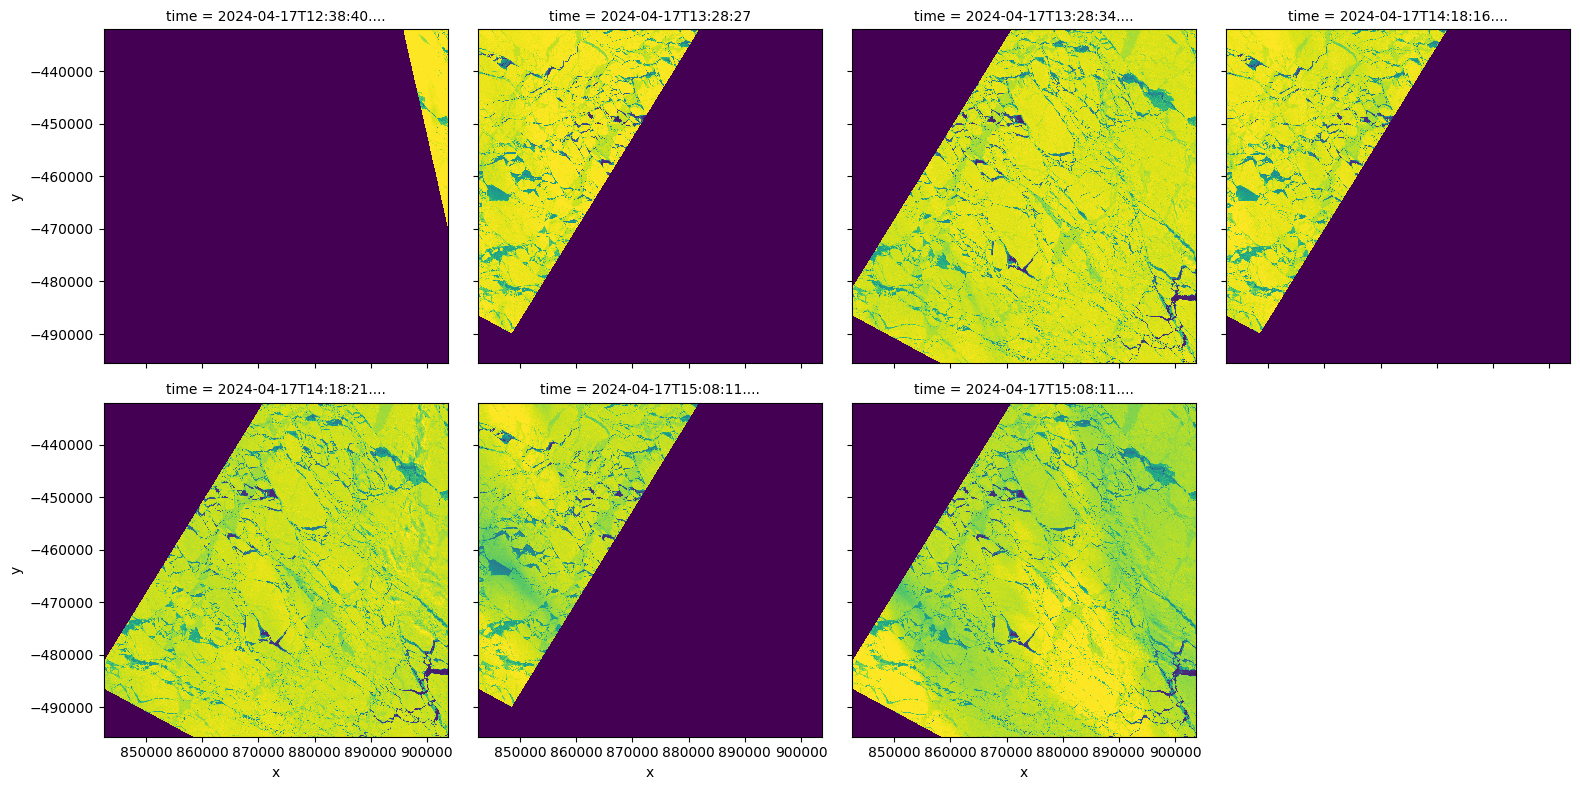

In [8]:
s2_scene.plot(
    robust=True,
    col='time',
    col_wrap=4,
    cmap='viridis',
    figsize=(16, 8),
    add_colorbar=False,
)

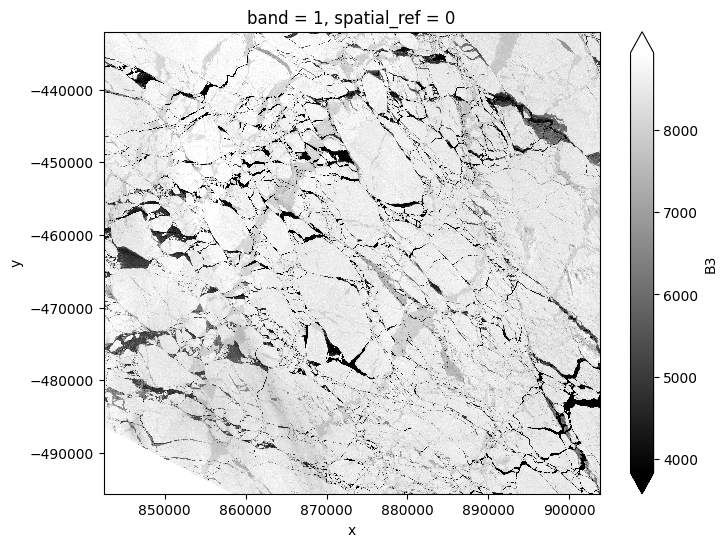

In [13]:
s2_sel = s2_scene.sel(time='2024-04-17T13')
s2_sel = s2_sel.where(s2_sel > 0).mean('time')
s2_sel.plot(figsize=(8, 6), cmap='gray', robust=True)

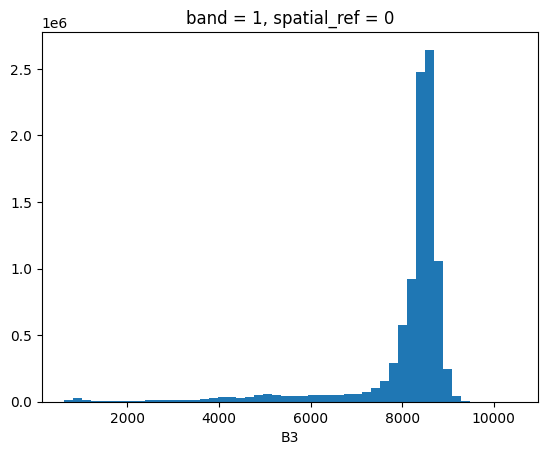

In [18]:
import matplotlib.pyplot as plt

_ = s2_sel.plot.hist(bins=50)
